In [52]:
from enum import Enum
import torch
import logging
import tqdm
import json
import os
import numpy as np
from dataset import RadarDataset
from model import UNet
from loss import cross_entropy_loss
from torch.utils.data import DataLoader
from config import N_LABELS
import torch.nn as nn
from runner import load_checkpoint, save_checkpoint, OptimizerChoice
from train import create_optimizer
from dotenv import load_dotenv
from common import get_scene
from encoder import Grid


load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# loading scene
sequence_id = "sequence_1"
scene_fn = os.path.join(os.getenv("DATA_LOCATION"), sequence_id, "scenes.json")
detections = get_scene(scene_fn)
tss = detections['timestamp'].unique()
print(detections['label_id'].value_counts())

# loading model for inference
chs = [8, 16, 32]
optimizer_choice = OptimizerChoice.ADAMW
model = UNet(chs=chs, n_classes=N_LABELS)
optimizer = create_optimizer(model, optimizer_choice, lr=1e-4)
model, optimizer, epoch = load_checkpoint(model, optimizer, "checkpoints/test_ep20.pth")

label_id
11    125516
0       5462
1        443
7         71
Name: count, dtype: int64


In [55]:
cur_dets = detections[detections["timestamp"] == tss[1]]

# encoding into grid
grid_fl = Grid(x_lims=(2, 100), y_lims=(-50, 20), cell_size=0.5)
grid_fl.fill_grid(cur_dets)
grid_fl.fill_grid(cur_dets, is_output=True)

input_data = torch.from_numpy(grid_fl.grid).permute(2, 0, 1)
out_data = torch.from_numpy(grid_fl.out_grid).permute(2, 0, 1)

In [58]:
out_data.unique()

tensor([0, 4], dtype=torch.uint8)

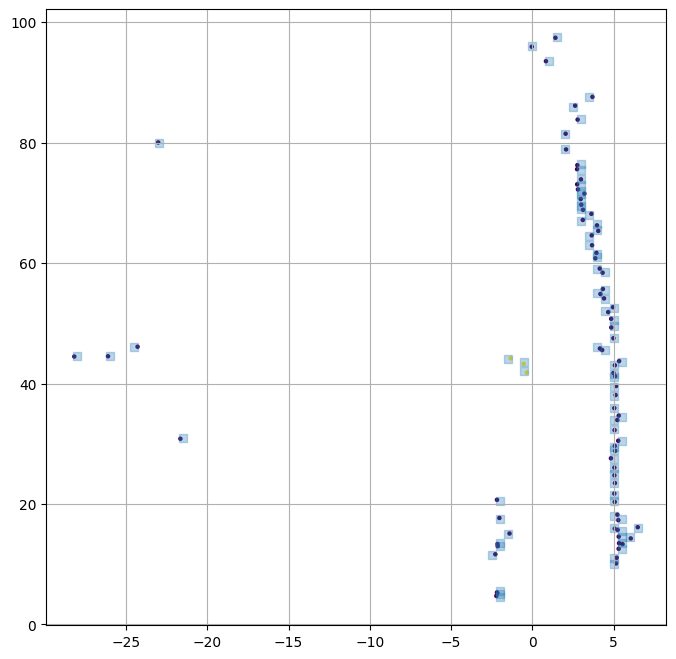

In [ ]:
# from config import label_to_index, CAR

# # inspecting grid
# _ ,_ , x_pos, y_pos = grid_fl.get_active_cells_positions()
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(cur_dets['y_cc'], cur_dets['x_cc'], c=cur_dets['vr_compensated'], s=5)
# ax.scatter(y_pos, x_pos, alpha=0.3, marker='s')
# ax.grid()

# x_inds, y_inds = np.where(grid_fl.out_grid[:, :, label_to_index[CAR]] > 0)
# x_pos = x_inds * grid_fl.cell_size + grid_fl.x_lims[0]
# y_pos = y_inds * grid_fl.cell_size + grid_fl.y_lims[0]

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(cur_dets['y_cc'], cur_dets['x_cc'], c=cur_dets['vr_compensated'], s=5)
# ax.scatter(y_pos, x_pos, alpha=0.3, marker='s')
# ax.grid()

In [159]:
import torch.nn as nn

loss = nn.CrossEntropyLoss()
input_ = torch.Tensor([
    [
        [0, 0, 1], 
        [0, 1, 0]
    ],
    [
        [1, 0, 0], 
        [1, 1, 0]
    ]
])
# input_ = torch.Tensor(
#     [
#         [1, 1, 1], 
#         [1, 1, 1]
#     ]
# )

input_ = input_.unsqueeze(0)

target = input_
target_random = torch.randn(input_.shape).softmax(dim=1)
# target = torch.ones(input_.shape)

target_indices = torch.argmax(target, dim=1)
print(loss(input_, target_indices))
target_indices = torch.argmax(target_random, dim=1)
print(loss(input_, target_indices))
# input_ = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input_, target)
# output

tensor(0.5032)
tensor(0.8365)


In [110]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output

tensor(2.2250, grad_fn=<DivBackward1>)